In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time

import root_pandas as rpd
from root_pandas import read_root

mpl.rcParams['figure.figsize'] = 6.2,3.5
mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['legend.fontsize']= 15

Welcome to JupyROOT 6.15/01


In [13]:
class correlation:
    def __init__(self, ntriggers, df, df_mixed):
        
        self.nbins_dphi = 18#32
        self.nbins_deta = 18#16
        self.ntriggers = ntriggers
        self.phibins = np.linspace(0, np.pi, self.nbins_dphi+1)#16+1) #was 16+1
        #        self.phibins = np.linspace(-np.pi, np.pi, self.nbins_dphi+1)#16+1) #was 16+1
        #self.etabins = np.linspace(-np.pi, np.pi, self.nbins_deta+1)#16+1) #was 16+1
        self.etabins = np.linspace(-0.5, 4, self.nbins_deta+1) #was 16+1        
        
        
        self.bincenters_dphi = [np.mean([x, y]) for (x, y) in zip(self.phibins[:-1], self.phibins[1:])]
        self.bincenters_deta = [np.mean([x, y]) for (x, y) in zip(self.etabins[:-1], self.etabins[1:])]
        
        dphi = list(df['dphi'])
        dphi_lab = list(df['dphi_lab'])
        deta = list(df['dy'])
        mixed_dphi = list(df_mixed['dphi'])
        mixed_dphi_lab = list(df_mixed['dphi_lab'])
        mixed_deta = list(df_mixed['dy'])
        
        self.numberofpairs = df.shape[0]
        
        #1D correlations
        #dphi
        self.sameh_dphi =myHisto(dphi, self.phibins) # np.histogram(dphi, self.phibins)[0]
        self.sameh_dphi.norm(ntriggers)   
        self.mixh_dphi  =myHisto(mixed_dphi, self.phibins)
        norm = sum(self.mixh_dphi.y)/self.nbins_dphi
        self.mixh_dphi.norm(norm)
        self.corr_dphi = np.true_divide(self.sameh_dphi.y,self.mixh_dphi.y)
        self.corr_dphi_err = np.true_divide(self.sameh_dphi.yerr,self.mixh_dphi.y)

        #dphi in lab frame
        self.sameh_dphi_lab =myHisto(dphi_lab, self.phibins) # np.histogram(dphi, self.phibins)[0]
        self.sameh_dphi_lab.norm(ntriggers)   
        self.mixh_dphi_lab  =myHisto(mixed_dphi_lab, self.phibins)
        norm = sum(self.mixh_dphi_lab.y)/self.nbins_dphi
        self.mixh_dphi_lab.norm(norm)
        self.corr_dphi_lab = np.true_divide(self.sameh_dphi_lab.y,self.mixh_dphi_lab.y)
        self.corr_dphi_lab_err = np.true_divide(self.sameh_dphi_lab.yerr,self.mixh_dphi_lab.y)

        
        
        
        self.sameh_deta =myHisto(deta, self.etabins) # np.histogram(dphi, self.phibins)[0]
        self.sameh_deta.norm(ntriggers)
        self.mixh_deta  =myHisto(mixed_deta, self.etabins)
        norm = sum(self.mixh_deta.y)/self.nbins_deta #sum(self.mixh_deta.y)/self.nbins_deta
        self.mixh_deta.norm(norm)
        #self.corr_deta     = np.true_divide(self.sameh_deta.y,self.mixh_deta.y)
        #self.corr_deta_err = np.true_divide(self.sameh_deta.yerr,self.mixh_deta.y)

        # 2D correlations
        
        #self.sameh_2d, self.xedges,self.yedges = np.histogram2d(deta,dphi, [self.etabins,self.phibins])
        #self.mixh_2d, self.xedges,self.yedges = np.histogram2d(mixed_deta,mixed_dphi, [self.etabins,self.phibins])

        #get correlation function
        #self.corr_2d = np.true_divide(self.sameh_2d,self.mixh_2d)
        #self.extent = [self.xedges[0], self.xedges[-1], self.yedges[0], self.yedges[-1]]
        
        #MASS: 
        self.hmass, self.hmass_x = np.histogram(df['mass'],range=(0.0,2.0),density=True, bins=50)
        self.hmass_mix, self.hmass_x = np.histogram(df_mixed['mass'],range=(0.0,2.0),density=True,bins=50)
        self.hmass_x = (self.hmass_x[1:] + self.hmass_x[:-1])/2.0
        
        self.hxmass, self.hxmass_x = np.histogram(df['missing_mass'],range=(0.0,2.0),density= True, bins=50)
        self.hxmass_mix, self.hxmass_x = np.histogram(df_mixed['missing_mass'],range=(0.0,2.0),density=True,bins=50)
        self.hxmass_x = (self.hxmass_x[1:] + self.hxmass_x[:-1])/2.0
        
        self.t, self.t_x = np.histogram(df['t'],range=(0.0,5.0), density= True, bins=50)
        self.t_mix, self.t_x = np.histogram(df_mixed['t'],range=(0.0,5.0),density=True,bins=50)
        self.t_x = (self.t_x[1:] + self.t_x[:-1])/2.0
        
        self.dipion_pt, self.dipion_pt_x = np.histogram(df['dipion_pt'],range=(0.0,2.0), density = True, bins=50)
        self.dipion_pt_mix, self.dipion_pt_x = np.histogram(df_mixed['dipion_pt'],range=(0.0,2.0),density=True,bins=50)
        self.dipion_pt_x = (self.dipion_pt_x[1:] + self.dipion_pt_x[:-1])/2.0
        

    def normalize(self,norma):
        #print 'sum entrifes beforoe normalization' ,np.sum(self.corr_dphi)
        #print 'requested normalization' , norma
        self.corr_dphi     = np.true_divide(self.corr_dphi, norma)
        #print ' sum entries after normalization', np.sum(self.corr_dphi)
        self.corr_dphi_err = np.true_divide(self.corr_dphi_err,norma)
        return 

class comparison:
    def __init__(self, corr_A, corr_D):
        
        self.corr_A = corr_A.corr_dphi
        self.corr_D = corr_D.corr_dphi
        self.err_A  = corr_A.corr_dphi_err
        self.err_D  = corr_D.corr_dphi_err
        self.dif_err = np.sqrt(np.power(self.err_A,2.0)+np.power(self.err_D,2.0)) #error for difference
        self.diff  = np.subtract(self.corr_A,self.corr_D)
        self.ratio = np.true_divide(self.corr_A,self.corr_D)
        self.ratio_err = np.sqrt(np.power(np.divide(self.err_A,self.corr_A),2.0)+np.power(np.divide(self.err_D,self.corr_D),2.0))*self.ratio 
        
        
class myHisto:
    def __init__(self, data, bins):
        self.bins = bins
        self.y    = np.histogram(data, self.bins)[0]
        self.yerr = np.sqrt(self.y)
    def norm(self, norm=1.0):
        self.y = np.true_divide(self.y, norm)
        self.yerr = np.true_divide(self.yerr, norm)

In [3]:
def getRatio(df_A,df_D,df_trigger_A,df_trigger_D, variable='z_asso',trig_cut = 'z>0.5', pair_cut='',minz=0.05,maxz=0.5,nbins=12):
    #get number of pions with z>0.5
    norm_A = df_trigger_A.query(trig_cut).shape[0]
    norm_D = df_trigger_D.query(trig_cut).shape[0]
    y_A, x_conditional = np.histogram(df_A.query(trig_cut+pair_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    y_D, x_conditional = np.histogram(df_D.query(trig_cut+pair_cut)[variable],bins=np.logspace(np.log10(minz), np.log10(maxz),nbins))
    x_conditional = (x_conditional[1:] + x_conditional[:-1])/2.0
    err_A = np.true_divide(np.sqrt(y_A),y_A)
    err_D = np.true_divide(np.sqrt(y_D),y_D)
    y_A = np.true_divide(y_A,norm_A)
    y_D = np.true_divide(y_D,norm_D)
    ratio_conditional = np.true_divide(y_A,y_D)
    error_conditional = np.multiply(ratio_conditional, np.sqrt(np.power(err_A,2.0) + np.power(err_D,2.0)))
    
    return ratio_conditional,error_conditional,x_conditional

In [4]:
def applyCut(inputDataframe, cut, text=None):
    nbeforecut = inputDataframe.shape[0]
    cutDataframe = inputDataframe.query(cut)
    if text:
        print text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)'
    return cutDataframe
def applyCuts(fullDataframe,name='default',isMC=False): 
    dataframe = fullDataframe
    print 'Entries before cut ', dataframe.shape[0]
    dataframe.eval('inelasticity = Nu/5.014', inplace=True)
    dataframe.eval('E = z*Nu', inplace=True)
    dataframe.eval('P = sqrt(E*E-0.140*0.140)', inplace=True)
    
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    dataframe = applyCut(dataframe, 'W>2.0', 'W>2.0 :')
    #dataframe = applyCut(dataframe, 'Nu>3.5', 'Nu>3.5 :')

    dataframe = applyCut(dataframe, 'z>0.5', 'z>0.5 :')
    dataframe = applyCut(dataframe, 'P <2.5 ', 'P<2.5 ')
    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    return dataframe

def applyCutsPair(fullDataframe,name='default'):
    print 'Starting election on dipion variables'
    dataframe = fullDataframe
    dataframe.eval('z_tot = z+z_asso', inplace=True)
    dataframe.eval('E_asso = z_asso*Nu', inplace=True)
    dataframe.eval('P_asso = sqrt(E_asso*E_asso-0.140*0.140)', inplace=True)
    #dataframe = applyCut(dataframe, 'z+z_asso<0.8', 'z+z_asso<0.8')
    return dataframe

def printPairBreakdown(dataframe):
    
    print 'Pairs with Leading pi+', dataframe.query('pid==211').shape[0]
    print 'Pairs with Leading pi-', dataframe.query('pid==-211').shape[0]
    print 'Pairs with Sub-Leading pi+', dataframe.query('pid_asso==211').shape[0]
    print 'Pairs with Sub-Leading pi-', dataframe.query('pid_asso==-211').shape[0]
    print 'pi+ pi+ pairs',dataframe.query('pid==211 and pid_asso==211').shape[0]
    print 'pi- pi- pairs',dataframe.query('pid==-211 and pid_asso==-211').shape[0]
    print 'pi+ pi- pairs',dataframe.query('pid==211 and pid_asso==-211').shape[0]
    print 'pi- pi+ pairs',dataframe.query('pid==-211 and pid_asso==211').shape[0]
    print '//////////////////////////////////////////////////////'
    return 


## Get data from Ntuples to dataframes

In [5]:
#this needs to be read in chunks otherwise it uses all memory. (from https://github.com/scikit-hep/root_pandas)
def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    for df in read_root(filename, treename, chunksize=100000) :
        #print df.shape[0]
        dataframe = pd.concat([dataframe,df])
    
    print dataframe.shape[0]
    return dataframe
    

In [6]:
df = {}
df_trigger = {}

for target in ['Pb']:#,'Fe','C']:
    print 'Getting dataframes from target %s'%target
    df[target]=getdatainChunks('Pairs_%s.root'%target, target)
    df['%s_mix'%target] = getdatainChunks('Pairs_%s.root'%target, '%s_mix'%target)
    df['D_%s'%target]= getdatainChunks('Pairs_%s.root'%target, 'D_%s'%target)
    df['D_%s_mix'%target] = getdatainChunks('Pairs_%s.root'%target, 'D_%s_mix'%target)
    print 'Get trigger dataframes from target%s'%target
    df_trigger['%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('Pairs_%s.root'%target, 'D_%s_trigger'%target)
    



Getting dataframes from target Pb
110447
641296
574977
2910316
Get trigger dataframes from targetPb
527766
2349115


In [ ]:
df['D'] = pd.concat([df['D_Pb'],df['D_Fe'],df['D_C']]) #simply combine the deuterium results for all targets
df['D_mix'] = pd.concat([df['D_Pb_mix'],df['D_Fe_mix'],df['D_C_mix']]) #simply combine the deuterium results for all targets
df_trigger['D_trigger'] = pd.concat([df_trigger['D_Pb_trigger'],df_trigger['D_Fe_trigger'],df_trigger['D_C_trigger']]) #simply combine the deuterium results for all targets



## Apply selection

In [7]:
#dataframees with pairs
for key in df.keys():
    print key
    df[key] = applyCuts(df[key])
    printPairBreakdown(df[key])
    df[key] = applyCutsPair(df[key])
    
for key in df_trigger.keys():
    print key
    df_trigger[key] = applyCuts(df_trigger[key])

Pb
Entries before cut  110447
Q2>1.0 : 110447  (100.00  %)
W>2.0 : 110447  (100.00  %)
z>0.5 : 48356  (43.78  %)
P<2.5  41888  (86.62  %)
inelasticity < 0.85 40587  (96.89  %)
Pairs with Leading pi+ 32507
Pairs with Leading pi- 8080
Pairs with Sub-Leading pi+ 18963
Pairs with Sub-Leading pi- 21624
pi+ pi+ pairs 11301
pi- pi- pairs 418
pi+ pi- pairs 21206
pi- pi+ pairs 7662
//////////////////////////////////////////////////////
Starting election on dipion variables
D_Pb
Entries before cut  574977
Q2>1.0 : 574977  (100.00  %)
W>2.0 : 574976  (100.00  %)
z>0.5 : 273045  (47.49  %)
P<2.5  237372  (86.94  %)
inelasticity < 0.85 231672  (97.60  %)
Pairs with Leading pi+ 183897
Pairs with Leading pi- 47775
Pairs with Sub-Leading pi+ 101382
Pairs with Sub-Leading pi- 130290
pi+ pi+ pairs 54652
pi- pi- pairs 1045
pi+ pi- pairs 129245
pi- pi+ pairs 46730
//////////////////////////////////////////////////////
Starting election on dipion variables
D_Pb_mix
Entries before cut  2910316
Q2>1.0 : 2910

## Get R_2h for various selections 

In [ ]:
#nominal (no selection)
r_C, err_C,x = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'])
r_Fe, err_Fe,x = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'])
r_Pb, err_Pb,x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'])

## Get R_2h in different mass bins

In [ ]:
#mass
r_C_low, err_C_low,x = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],pair_cut=' and mass<0.6')
r_Fe_low, err_Fe_low,x = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'],pair_cut=' and mass<0.6')
r_Pb_low, err_Pb_low,x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],pair_cut=' and mass<0.6')

r_C_middle, err_C_middle,x = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],pair_cut=' and mass<1.0 and mass>0.6')
r_Fe_middle, err_Fe_middle,x = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'],pair_cut=' and mass<1.0 and mass>0.6')
r_Pb_middle, err_Pb_middle,x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],pair_cut=' and mass<1.0 and mass>0.6')

r_C_high, err_C_high,x = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],pair_cut=' and mass>1.0 and mass<1.5')
r_Fe_high, err_Fe_high,x = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'],pair_cut=' and mass>1.0 and mass<1.5')
r_Pb_high, err_Pb_high,x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],pair_cut=' and mass>1.0 and mass<1.5')

r_C_veryhigh, err_C_veryhigh,x = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],pair_cut=' and mass>1.0 and mass<1.5')
r_Fe_veryhigh, err_Fe_veryhigh,x = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'],pair_cut=' and mass>1.0 and mass<1.5')
r_Pb_veryhigh, err_Pb_veryhigh,x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],pair_cut=' and mass>1.0 and mass<1.5')


## R_2h data from HERMES and Neutrino buble-chamber experiment

In [ ]:
#hermes data:
hermes_y = {}
hermes_ystat = {}
hermes_ysyst = {}
hermes_ytotal = {}

#DATA FROM SELECTIO1 OF http://www-hermes.desy.de/notes/pub/publications.html
hermes_x = {}
hermes_x['Kr'] = [0.09,0.15,0.24,0.35,0.44]
hermes_x['N'] = np.subtract(hermes_x['Kr'],0.003)
hermes_x['Xe'] = np.subtract(hermes_x['Kr'],-0.003)

#nitrogen, atomic number 7
hermes_y['N']     = [1.0324, 0.9781,0.9293,0.8678,0.8822]
hermes_ystat['N'] = [0.0767,0.0268,0.0323,0.0478,0.0601]
hermes_ysyst['N'] = [0.0206,0.0196,0.0186,0.0174,0.0176]
hermes_ytotal['N'] = np.sqrt(np.power(hermes_ystat['N'],2.0)+np.power(hermes_ysyst['N'],2.0))

#krypton, atomic number 36
hermes_y['Kr'] = [1.2072,0.9180,0.8822,0.8631,1.0314]
hermes_ystat['Kr'] = [0.1342,0.0366,0.0452,0.0661,0.0972]
hermes_ysyst['Kr'] =[0.0241,0.0184,0.0176,0.0173,0.0206]
hermes_ytotal['Kr'] = np.sqrt(np.power(hermes_ystat['Kr'],2.0)+np.power(hermes_ysyst['Kr'],2.0))

hermes_y['Xe'] = [1.1648,0.9345,0.9242,0.8128,0.9373]
hermes_ystat['Xe'] = [0.1205,0.0359,0.0433,0.0614,0.0808]
hermes_ysyst['Xe'] = [0.0233,0.0187,0.0185,0.0163,0.0187]
hermes_ytotal['Xe'] = np.sqrt(np.power(hermes_ystat['Xe'],2.0)+np.power(hermes_ysyst['Xe'],2.0))


neutrino_x = [0.10763636363636367, 0.18618181818181817,0.25163636363636366,0.3345454545454546]
neutrino_y = [1.4535664335664338, 1.0148378893833438,  1.0373426573426574, 0.8784361093452003]
neutrino_yerror =[1.5794405594405596, 1.112739987285442, 1.1422377622377624,1.004310235219326]
neutrino_yerror = np.subtract(neutrino_yerror,neutrino_y)

fig = plt.figure(figsize=(8,6))



plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],label='Hermes, $^{14}N$',fmt='o')
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],label='Hermes, $^{84}Kr$',fmt='o')
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],label='Hermes, $^{131}Xe$',fmt='o')
plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,label='SKAT, $A_{eff}=21$',fmt='o')
plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)

plt.tight_layout()
plt.legend(frameon=False)
plt.savefig('PreviousData.png')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))

plt.errorbar(x+0.002,r_C,yerr=err_C,label='This work,  $^{12}_{6}C$',fmt='ro',ms=8,lw=3,capsize=5)
plt.errorbar(x,r_Fe,yerr=err_Fe,label='This work,  $^{56}_{26}Fe$',fmt='bo',ms=8,lw=3,capsize=5)
plt.errorbar(x-0.002,r_Pb,yerr=err_Pb,label='This work,  $^{208}_{82}Pb$',fmt='go',ms=8,lw=3,capsize=5)
plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',label='HERMES, $^{14}_{7}N$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',label='HERMES, $^{84}_{36}Kr$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',label='HERMES, $^{131}_{54}Xe$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)



plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

#plt.ylim([0.5,1.5])
plt.xlim([0.00,0.5])


plt.axhline(y=1.0,color='red',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=2)

plt.tight_layout()
plt.savefig('ComparisonWithHermes_Linear.png')


plt.xlim([0.05,0.5])

plt.xscale('log')
plt.savefig('ComparisonWithHermes_Log.png')

plt.show()

## Conditional z2 distribution ratio for z>0.5

## R2h in mass bins

In [ ]:
fig, axs = plt.subplots(1, 3,sharex=True, sharey=True, figsize=(14,5), gridspec_kw={'hspace': 0, 'wspace':0})


mpl.rcParams['axes.labelsize'] = 17
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['errorbar.capsize'] = 5
mpl.rcParams['legend.fontsize']= 15

axs[0].errorbar(x,r_C_low,yerr=err_C_low,label='C',fmt='og')
axs[0].errorbar(x-0.003,r_Fe_low,yerr=err_Fe_low,label='Fe',fmt='ob')
axs[0].errorbar(x+0.003,r_Pb_low,yerr=err_Pb_low,label='Pb',fmt='or')
axs[0].legend(frameon=False)
axs[0].axhline(y=1.0,color='black',linestyle='--')
axs[0].set_title('0.3< $M_{\pi\pi}$ <0.6 GeV',fontsize=16)
plt.xscale('log')
#plt.ylim([0.5,1.5])

plt.xlim([0.05,0.5])

axs[1].errorbar(x,r_C_middle,yerr=err_C_middle,label='C',fmt='og')
axs[1].errorbar(x-0.003,r_Fe_middle,yerr=err_Fe_middle,label='Fe',fmt='ob')
axs[1].errorbar(x+0.003,r_Pb_middle,yerr=err_Pb_middle,label='Pb',fmt='or')
axs[1].axhline(y=1.0,color='black',linestyle='--')
axs[1].set_title('0.6< $M_{\pi\pi}$ <1.0 GeV',fontsize=16)
axs[1].legend(frameon=False)

axs[2].errorbar(x,r_C_high,yerr=err_C_high,label='C',fmt='og')
axs[2].errorbar(x-0.003,r_Fe_high,yerr=err_Fe_high,label='Fe',fmt='ob')
axs[2].errorbar(x+0.003,r_Pb_high,yerr=err_Pb_high,label='Pb',fmt='or')
axs[2].axhline(y=1.0,color='black',linestyle='--')
axs[2].set_title('1.0 < $M_{\pi\pi}$ <1.5 GeV',fontsize=16)
axs[2].legend(frameon=False)

##axs[3].errorbar(x,r_C_veryhigh,yerr=err_C_veryhigh,label='C',fmt='og')
##axs[3].errorbar(x-0.003,r_Fe_veryhigh,yerr=err_Fe_veryhigh,label='Fe',fmt='ob')
##axs[3].errorbar(x+0.003,r_Pb_veryhigh,yerr=err_Pb_veryhigh,label='Pb',fmt='or')
##axs[3].axhline(y=1.0,color='black',linestyle='--')
##axs[3].set_title('1.5 < $M_{\pi\pi}$ <2.0 GeV')
##axs[3].legend(frameon=False)

axs[0].xaxis.set_label_text('$z_{2}$',fontsize=18)
axs[1].xaxis.set_label_text('$z_{2}$',fontsize=18)
axs[2].xaxis.set_label_text('$z_{2}$',fontsize=18)

axs[0].yaxis.set_label_text('$R_{2h}$',fontsize=18)

plt.tight_layout()
plt.savefig('R2h_massdependence.png')
plt.show()

## Event Mixing corrections

z> 0.50 and z<= 1.00  and z_asso>0.05 and z_asso<=0.08
233622
z> 0.50 and z<= 1.00  and z_asso>0.08 and z_asso<=0.15
233622
z> 0.50 and z<= 1.00  and z_asso>0.15 and z_asso<=0.30
233622
z> 0.50 and z<= 1.00  and z_asso>0.30 and z_asso<=0.50
233622


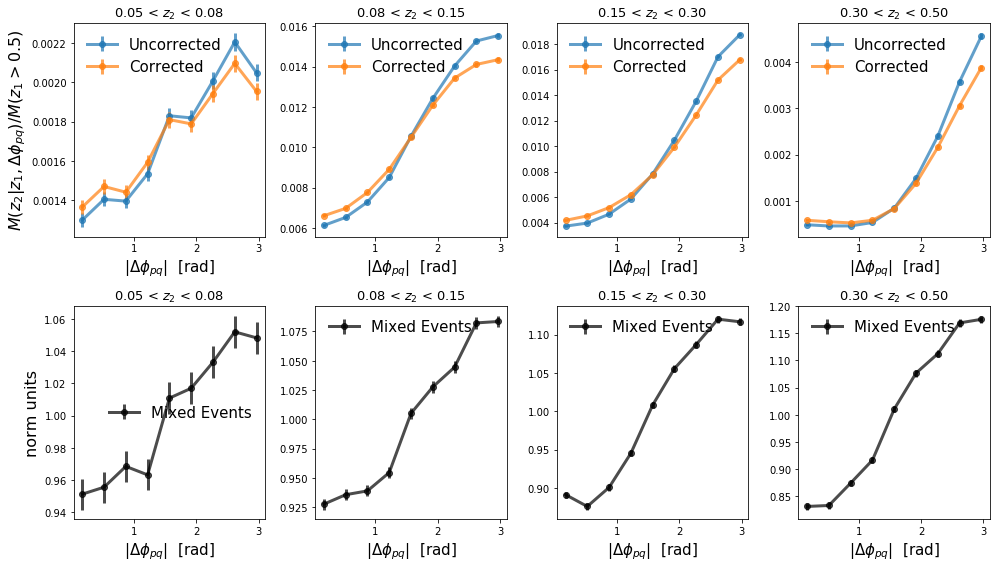

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(14,8))
Edges = [0.4, 0.5,0.6,0.7,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.08, 0.15,0.3,0.5]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f '%(0.5,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
    query_total = query_trigger + ' and '+ query_asso
    print query_total
    print df_trigger['Pb_trigger'].query(query_trigger).shape[0]
    corr = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
    corr_D = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
    
    axs[0,j].errorbar(corr_D.bincenters_dphi, corr_D.sameh_dphi.y, yerr=corr_D.sameh_dphi.yerr, linewidth=3.0,alpha=0.7,fmt='-o', label='Uncorrected')
    axs[0,j].errorbar(corr_D.bincenters_dphi, corr_D.corr_dphi, yerr=corr_D.corr_dphi_err, linewidth=3.0,alpha=0.7,fmt='-o', label='Corrected')

    axs[0,j].xaxis.set_label_text("|$\Delta\phi_{pq}$|  [rad]", fontsize=15)
    axs[0,j].legend(loc='best',frameon=False)
    axs[0,0].yaxis.set_label_text(r'$M(z_{2}|z_{1}, \Delta\phi_{pq})/M(z_{1}>0.5)$',fontsize=16)
    axs[0,j].set_title('%2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

    axs[1,j].set_title('%2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)
    axs[1,j].errorbar(corr_D.bincenters_dphi, corr_D.mixh_dphi.y, yerr=corr_D.mixh_dphi.yerr, linewidth=3.0,alpha=0.7,fmt='-ko', label='Mixed Events')
    axs[1,0].yaxis.set_label_text('norm units',fontsize=16)
    axs[1,j].xaxis.set_label_text("|$\Delta\phi_{pq}$|  [rad]", fontsize=15)
    axs[1,j].legend(loc='best',frameon=False)

        
plt.tight_layout()
plt.savefig('EventMixing_AzimuthalCorrelations.png')

## Event mixing corrections for lab frame

z> 0.50 and z<= 1.00  and z_asso>0.05 and z_asso<=0.08
233622
z> 0.50 and z<= 1.00  and z_asso>0.08 and z_asso<=0.15
233622
z> 0.50 and z<= 1.00  and z_asso>0.15 and z_asso<=0.30
233622
z> 0.50 and z<= 1.00  and z_asso>0.30 and z_asso<=0.50
233622


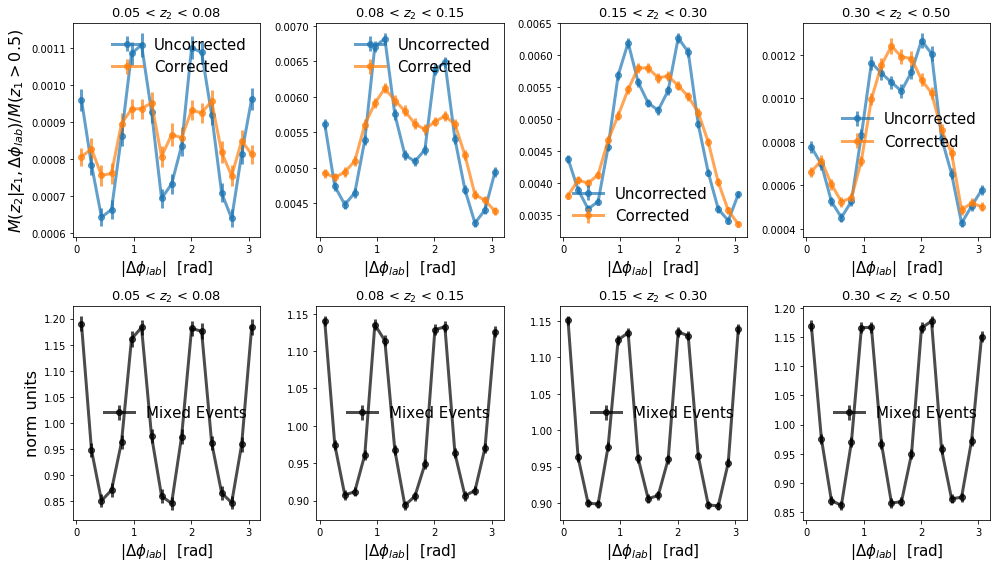

In [16]:
fig, axs = plt.subplots(2, 4,figsize=(14,8))
Edges = [0.4, 0.5,0.6,0.7,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.08, 0.15,0.3,0.5]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f '%(0.5,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
    query_total = query_trigger + ' and '+ query_asso
    print query_total
    print df_trigger['Pb_trigger'].query(query_trigger).shape[0]
    corr = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
    corr_D = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
    
    axs[0,j].errorbar(corr_D.bincenters_dphi, corr_D.sameh_dphi_lab.y, yerr=corr_D.sameh_dphi_lab.yerr, linewidth=3.0,alpha=0.7,fmt='-o', label='Uncorrected')
    axs[0,j].errorbar(corr_D.bincenters_dphi, corr_D.corr_dphi_lab, yerr=corr_D.corr_dphi_lab_err, linewidth=3.0,alpha=0.7,fmt='-o', label='Corrected')

    axs[0,j].xaxis.set_label_text("|$\Delta\phi_{lab}$|  [rad]", fontsize=15)
    axs[0,j].legend(loc='best',frameon=False)
    axs[0,0].yaxis.set_label_text(r'$M(z_{2}|z_{1}, \Delta\phi_{lab})/M(z_{1}>0.5)$',fontsize=16)
    axs[0,j].set_title('%2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

    axs[1,j].set_title('%2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)
    axs[1,j].errorbar(corr_D.bincenters_dphi, corr_D.mixh_dphi_lab.y, yerr=corr_D.mixh_dphi_lab.yerr, linewidth=3.0,alpha=0.7,fmt='-ko', label='Mixed Events')
    axs[1,0].yaxis.set_label_text('norm units',fontsize=16)
    axs[1,j].xaxis.set_label_text("|$\Delta\phi_{lab}$|  [rad]", fontsize=15)
    axs[1,j].legend(loc='best',frameon=False)

        
plt.tight_layout()
plt.savefig('EventMixing_AzimuthalCorrelations_LabFrame.png')

# Azimuthal correlations

In [ ]:
fig, axs = plt.subplots(2, 4,sharex=True,sharey='row', figsize=(14,8), gridspec_kw={'wspace':0, 'hspace':0})
Edges = [0.4, 0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.08, 0.15,0.3,0.5]
#asso_Edges =np.logspace(np.log10(0.05), np.log10(0.5),5)

asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f and pid>0 '%(0.5,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f and pid>0 and pid_asso>0'%(asso_bin[0],asso_bin[1])
    query_total = query_trigger + ' and '+ query_asso
    print query_total
    
    corr_C = correlation(df_trigger['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
    corr_D_C = correlation(df_trigger['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
    norma = np.sum(corr_D_C.corr_dphi)
    corr_D_C.normalize(norma)
    corr_C.normalize(norma)
    
    ##LEAD
    corr_Pb = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
    corr_D_Pb = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
    norma = np.sum(corr_D_Pb.corr_dphi)
    corr_Pb.normalize(norma)
    corr_D_Pb.normalize(norma)
    
    ##IRON
    corr_Fe = correlation(df_trigger['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
    corr_D_Fe = correlation(df_trigger['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
    norma = np.sum(corr_D_Fe.corr_dphi)
    corr_Fe.normalize(norma)
    corr_D_Fe.normalize(norma)

    comp_C = comparison(corr_C,corr_D_C)
    comp_Fe = comparison(corr_Fe,corr_D_Fe)
    comp_Pb = comparison(corr_Pb,corr_D_Pb)

    ##Combined deuterium for plotting purposes
    corr_D = correlation(df_trigger['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
    corr_D.normalize(np.sum(corr_D.corr_dphi))
    
    #plots:
    #correlations
    
    axs[0,j].errorbar(corr_D.bincenters_dphi, corr_D.corr_dphi, yerr=corr_D.corr_dphi_err, linewidth=3.0,alpha=0.7,fmt='-ko', label='D')
    axs[0,j].errorbar(corr_C.bincenters_dphi, corr_C.corr_dphi, yerr=corr_C.corr_dphi_err, linewidth=3.0,alpha=0.7,fmt='-ro', label='C')
    axs[0,j].errorbar(corr_Fe.bincenters_dphi, corr_Fe.corr_dphi, yerr=corr_Fe.corr_dphi_err, linewidth=3.0,alpha=0.7,fmt='-bo', label='Fe')
    axs[0,j].errorbar(corr_Pb.bincenters_dphi, corr_Pb.corr_dphi, yerr=corr_Pb.corr_dphi_err, linewidth=3.0,alpha=0.7,fmt='-go', label='Pb')

    
    axs[1,j].errorbar(corr_D.bincenters_dphi, comp_C.ratio, yerr=comp_C.ratio_err, linewidth=3.0,alpha=0.7,fmt='-ro')
    axs[1,j].errorbar(corr_D.bincenters_dphi, comp_Fe.ratio, yerr=comp_Fe.ratio_err, linewidth=3.0,alpha=0.7,fmt='-bo')
    axs[1,j].errorbar(corr_D.bincenters_dphi, comp_Pb.ratio, yerr=comp_Pb.ratio_err, linewidth=3.0,alpha=0.7,fmt='-go')

    #axs[j].errorbar(corr_Fe.bincenters_dphi, corr_Fe.corr_dphi, yerr=corr_Fe.corr_dphi_err, linewidth=3.0,alpha=0.7,fmt='-o', label='Fe')
    #axs[j].errorbar(corr_Pb.bincenters_dphi, corr_Pb.corr_dphi, yerr=corr_Pb.corr_dphi_err, linewidth=3.0,alpha=0.7,fmt='-o', label='Pb')
    
    axs[0,j].axhline(y=0.0,color='black',linestyle='--',alpha=0.5)
    axs[1,j].xaxis.set_label_text("|$\Delta\phi_{pq}$|  [rad]", fontsize=15)
    axs[0,j].legend(loc='best',frameon=False)
    axs[0,0].yaxis.set_label_text(r'$M(z_{2}|z_{1}, \Delta\phi_{pq})/M(z_{1}>0.5)$',fontsize=16)

    axs[1,0].yaxis.set_label_text(r'$R_{2h}(z_{1},z_{2}, \Delta\phi_{pq}) $',fontsize=16)
    axs[1,j].axhline(y=1.0,color='black',linestyle='--',alpha=0.5)

    axs[0,j].set_title('$z_{1}$> 0.5 \n %2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
plt.tight_layout()
plt.savefig('AzimuthalCorrelations.png')

## Missing Mass vs z2 (for fixed z1)

In [ ]:
fig, axs = plt.subplots(1, 4,sharex=True,sharey=True, figsize=(14,5), gridspec_kw={'wspace':0})
Edges = [0.4, 0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.1, 0.2,0.35,0.5]
#asso_Edges =np.logspace(np.log10(0.05), np.log10(0.5),5)

asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f '%(0.5,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f '%(asso_bin[0],asso_bin[1])
    query_total = query_trigger + ' and '+ query_asso
    print query_total
    
    corr_C = correlation(df_trigger['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
    corr_D_C = correlation(df_trigger['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
    norma = np.sum(corr_D_C.corr_dphi)
    corr_D_C.normalize(norma)
    corr_C.normalize(norma)
    
    ##LEAD
    corr_Pb = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
    corr_D_Pb = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
    norma = np.sum(corr_D_Pb.corr_dphi)
    corr_Pb.normalize(norma)
    corr_D_Pb.normalize(norma)
    
    ##IRON
    corr_Fe = correlation(df_trigger['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
    corr_D_Fe = correlation(df_trigger['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
    norma = np.sum(corr_D_Fe.corr_dphi)
    corr_Fe.normalize(norma)
    corr_D_Fe.normalize(norma)

    corr_D = correlation(df_trigger['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
    corr_D.normalize(np.sum(corr_D.corr_dphi))
    
    
    comp_C = comparison(corr_C,corr_D_C)
    comp_Fe = comparison(corr_Fe,corr_D_Fe)
    comp_Pb = comparison(corr_Pb,corr_D_Pb)

    axs[j].plot(corr_D.hxmass_x,corr_D.hxmass,label='D',alpha=0.8)
    axs[j].plot(corr_C.hxmass_x,corr_C.hxmass,label='C',alpha=0.8)
    axs[j].plot(corr_Fe.hxmass_x,corr_Fe.hxmass,label='Fe',alpha=0.8)
    axs[j].plot(corr_Pb.hxmass_x,corr_Pb.hxmass,label='Pb',alpha=0.8)
    plt.xlim([0.3,1.8])

    axs[j].axvline(x=0.938,linestyle='--',color='black',alpha=0.6)
    #axs[2].xaxis.set_label_text("Missing Mass  [GeV]", fontsize=13)
    axs[j].legend(loc='best',frameon=False)
    axs[j].set_title('$z_{1}$> 0.5 \n %2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)
    axs[j].xaxis.set_label_text("Missing Mass  [GeV]", fontsize=13)
    axs[j].yaxis.set_label_text("pdf")
        
plt.tight_layout()
plt.savefig('MissingMass.png')

## Dipion Mass vs z2 for fixed z1

In [ ]:
fig, axs = plt.subplots(1, 4,sharex=True, sharey=True,figsize=(14,5), gridspec_kw={'wspace':0})
Edges = [0.4, 0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.1, 0.15,0.20,0.25]
#asso_Edges =np.logspace(np.log10(0.05), np.log10(0.5),5)

asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    query_trigger = 'z> %2.2f and z<= %2.2f '%(0.4,1.0)
    query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
    query_total = query_trigger + ' and '+ query_asso
    print query_total
    
    corr_C = correlation(df_trigger['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
    corr_D_C = correlation(df_trigger['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
    norma = np.sum(corr_D_C.corr_dphi)
    corr_D_C.normalize(norma)
    corr_C.normalize(norma)
    
    ##LEAD
    corr_Pb = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
    corr_D_Pb = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
    norma = np.sum(corr_D_Pb.corr_dphi)
    corr_Pb.normalize(norma)
    corr_D_Pb.normalize(norma)
    
    ##IRON
    corr_Fe = correlation(df_trigger['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
    corr_D_Fe = correlation(df_trigger['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
    norma = np.sum(corr_D_Fe.corr_dphi)
    corr_Fe.normalize(norma)
    corr_D_Fe.normalize(norma)

    comp_C = comparison(corr_C,corr_D_C)
    comp_Fe = comparison(corr_Fe,corr_D_Fe)
    comp_Pb = comparison(corr_Pb,corr_D_Pb)

    
    corr_D = correlation(df_trigger['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
    corr_D.normalize(np.sum(corr_D.corr_dphi))

    axs[j].plot(corr_C.hmass_x,corr_D.hmass,label='D',alpha=0.8)
    #axs[j].plot(corr_C.hmass_x,corr_D_C.hmass_mix,label='D (mix)')

    axs[j].plot(corr_C.hmass_x,corr_C.hmass,label='C',alpha=0.8)
    axs[j].plot(corr_Fe.hmass_x,corr_Fe.hmass,label='Fe',alpha=0.8)
    axs[j].plot(corr_Pb.hmass_x,corr_Pb.hmass,label='Pb',alpha=0.8)
    #axs[j].fill(corr_D.hmass_x,corr_D.hmass_mix,label='(mixed)',alpha=0.4)
    #axs[j].fill(corr_Pb.hmass_x,corr_Pb.hmass_mix,label='(mixed Pb)',alpha=0.4)


    axs[j].axvline(x=0.770,linestyle='--',color='black',alpha=0.4)
    #axs[2].xaxis.set_label_text("Missing Mass  [GeV]", fontsize=13)
    axs[j].legend(loc='best',frameon=False)
    axs[j].set_title('$z_{1}$> 0.5 \n %2.2f < $z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)
    axs[j].xaxis.set_label_text("Dipion Mass  [GeV]", fontsize=13)
    axs[0].yaxis.set_label_text("pdf")
    plt.xlim([0.2,2.0])

        
plt.tight_layout()
plt.savefig('Dipion_InvariantMass_anti.png')

## 2D Missing Mass (z1,z2)

In [ ]:
fig, axs = plt.subplots(4, 3,sharex=True, sharey='row', figsize=(12,10), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.08, 0.15,0.30,0.5]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]


for j, asso_bin in enumerate(asso_bins):
    for i, trigger_bin in enumerate(bins):
        query_trigger = 'z> %2.2f and z<= %2.2f '%(trigger_bin[0],trigger_bin[1])
        query_asso = 'z_asso>%2.2f and z_asso<=%2.2f '%(asso_bin[0],asso_bin[1])
        query_total = query_trigger + ' and '+ query_asso
        print query_total
    
        corr_C = correlation(df_trigger['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
        corr_D_C = correlation(df_trigger['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
        norma = np.sum(corr_D_C.corr_dphi)
        corr_D_C.normalize(norma)
        corr_C.normalize(norma)
    
    ##LEAD
        corr_Pb = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
        corr_D_Pb = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
        norma = np.sum(corr_D_Pb.corr_dphi)
        corr_Pb.normalize(norma)
        corr_D_Pb.normalize(norma)
    
    ##IRON
        corr_Fe = correlation(df_trigger['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
        corr_D_Fe = correlation(df_trigger['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
        norma = np.sum(corr_D_Fe.corr_dphi)
        corr_Fe.normalize(norma)
        corr_D_Fe.normalize(norma)

        comp_C = comparison(corr_C,corr_D_C)
        comp_Fe = comparison(corr_Fe,corr_D_Fe)
        comp_Pb = comparison(corr_Pb,corr_D_Pb)
        
        corr_D = correlation(df_trigger['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
        corr_D.normalize(np.sum(corr_D.corr_dphi))
        
               
        axs[j,i].plot(corr_D.hxmass_x,corr_D.hxmass,label='D',alpha=0.8)
        axs[j,i].plot(corr_C.hxmass_x,corr_C.hxmass,label='C',alpha=0.8)
        axs[j,i].plot(corr_Fe.hxmass_x,corr_Fe.hxmass,label='Fe',alpha=0.8)
        axs[j,i].plot(corr_Pb.hxmass_x,corr_Pb.hxmass,label='Pb',alpha=0.8)
        #axs[j,i].fill(corr_Pb.hxmass_x,corr_Pb.hxmass_mix,label='(mixed)',alpha=0.4)

        plt.xlim([0.0,2.0])

        axs[j,i].axvline(x=0.938,linestyle='--',color='black',alpha=0.6)
        axs[3,i].xaxis.set_label_text("Missing Mass  [GeV]", fontsize=13)
        axs[0,i].set_title('%2.2f < $z^{1}$ < %2.2f'%(trigger_bin[0],trigger_bin[1]), fontsize=13)
        axs[j,i].legend(loc='best',frameon=False)
        axs[j,0].yaxis.set_label_text(r'$\frac{1}{N_{\mathrm{trigger}}} \mathrm{d}N_{\mathrm{pairs}}$',fontsize=18)
        axs[j,0].yaxis.set_label_text('%2.2f < $z^{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
plt.tight_layout()
plt.savefig('MissingMass_2D.png')

## 2D Missing Mass (z1,z1+z2)

In [ ]:
fig, axs = plt.subplots(4, 3,sharex=True, sharey='row', figsize=(12,10), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.5,0.6,0.7,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.55, 0.65,0.70,0.8,1.0]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]


for j, asso_bin in enumerate(asso_bins):
    for i, trigger_bin in enumerate(bins):
        query_trigger = 'z> %2.2f and z<= %2.2f '%(trigger_bin[0],trigger_bin[1])
        query_asso = 'z+z_asso>%2.2f and z+z_asso<=%2.2f '%(asso_bin[0],asso_bin[1])
        query_total = query_trigger + ' and '+ query_asso
        print query_total
    
        corr_C = correlation(df_trigger['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
        corr_D_C = correlation(df_trigger['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
        norma = np.sum(corr_D_C.corr_dphi)
        corr_D_C.normalize(norma)
        corr_C.normalize(norma)
    
    ##LEAD
        corr_Pb = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
        corr_D_Pb = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
        norma = np.sum(corr_D_Pb.corr_dphi)
        corr_Pb.normalize(norma)
        corr_D_Pb.normalize(norma)
    
    ##IRON
        corr_Fe = correlation(df_trigger['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
        corr_D_Fe = correlation(df_trigger['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
        norma = np.sum(corr_D_Fe.corr_dphi)
        corr_Fe.normalize(norma)
        corr_D_Fe.normalize(norma)

        comp_C = comparison(corr_C,corr_D_C)
        comp_Fe = comparison(corr_Fe,corr_D_Fe)
        comp_Pb = comparison(corr_Pb,corr_D_Pb)
        
        corr_D = correlation(df_trigger['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
        corr_D.normalize(np.sum(corr_D.corr_dphi))
        
        minimum_numberofpairs = np.min([corr_D.numberofpairs,corr_C.numberofpairs, corr_Fe.numberofpairs, corr_Pb.numberofpairs])

        
        if( minimum_numberofpairs>20):  
            axs[j,i].plot(corr_D.hxmass_x,corr_D.hxmass,label='D',alpha=0.8)
            axs[j,i].plot(corr_C.hxmass_x,corr_C.hxmass,label='C',alpha=0.8)
            axs[j,i].plot(corr_Fe.hxmass_x,corr_Fe.hxmass,label='Fe',alpha=0.8)
            axs[j,i].plot(corr_Pb.hxmass_x,corr_Pb.hxmass,label='Pb',alpha=0.8)
            #axs[j,i].fill(corr_D.hxmass_x,corr_D.hxmass_mix,label='(mixed)',alpha=0.4)

            plt.xlim([0.0,2.0])

            axs[j,i].axvline(x=0.938,linestyle='--',color='black',alpha=0.6)
            axs[3,i].xaxis.set_label_text("Missing Mass  [GeV]", fontsize=13)
            axs[0,i].set_title('%2.2f < $z_{1}$ < %2.2f'%(trigger_bin[0],trigger_bin[1]), fontsize=13)
            axs[j,i].legend(loc='best',frameon=False)
            axs[j,0].yaxis.set_label_text('%2.2f < $z_{1}+z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
plt.tight_layout()
plt.savefig('MissingMass_2D_z1z2.png')

## 2D Invariant Mass (z1, z2)

In [ ]:
fig, axs = plt.subplots(4, 3,sharex=True, sharey='row', figsize=(12,10), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.08, 0.15,0.30,0.5]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]

for j, asso_bin in enumerate(asso_bins):
    for i, trigger_bin in enumerate(bins):
        query_trigger = 'z> %2.2f and z<= %2.2f '%(trigger_bin[0],trigger_bin[1])
        query_asso = 'z_asso>%2.2f and z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
        query_total = query_trigger + ' and '+ query_asso
        print query_total
    
        corr_C = correlation(df_trigger['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
        corr_D_C = correlation(df_trigger['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
        norma = np.sum(corr_D_C.corr_dphi)
        corr_D_C.normalize(norma)
        corr_C.normalize(norma)
    
    ##LEAD
        corr_Pb = correlation(df_trigger['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
        corr_D_Pb = correlation(df_trigger['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
        norma = np.sum(corr_D_Pb.corr_dphi)
        corr_Pb.normalize(norma)
        corr_D_Pb.normalize(norma)
    
    ##IRON
        corr_Fe = correlation(df_trigger['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
        corr_D_Fe = correlation(df_trigger['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
        norma = np.sum(corr_D_Fe.corr_dphi)
        corr_Fe.normalize(norma)
        corr_D_Fe.normalize(norma)

        comp_C = comparison(corr_C,corr_D_C)
        comp_Fe = comparison(corr_Fe,corr_D_Fe)
        comp_Pb = comparison(corr_Pb,corr_D_Pb)
        
        corr_D = correlation(df_trigger['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
        corr_D.normalize(np.sum(corr_D.corr_dphi))
               
        axs[j,i].plot(corr_D.hmass_x,corr_D.hmass,label='D')
        axs[j,i].plot(corr_C.hmass_x,corr_C.hmass,label='C')
        axs[j,i].plot(corr_Fe.hmass_x,corr_Fe.hmass,label='Fe')
        axs[j,i].plot(corr_Pb.hmass_x,corr_Pb.hmass,label='Pb')
        axs[j,i].fill(corr_Pb.hmass_x,corr_Pb.hmass_mix,label='mixed',alpha=0.4)
        #axs[j,i].fill(corr_Fe.hmass_x,corr_Fe.hmass_mix,label='Fe (mix)',alpha=0.4)
        
        axs[j,i].axvline(x=0.770,color='black',alpha=0.6,linestyle='--')
        axs[2,i].xaxis.set_label_text("Dipion Mass  [GeV]", fontsize=13)
        axs[0,i].set_title('%2.2f < $z^{1}$ < %2.2f'%(trigger_bin[0],trigger_bin[1]), fontsize=13)
        axs[j,i].legend(loc='best',frameon=False)
        axs[j,0].yaxis.set_label_text(r'$\frac{1}{N_{\mathrm{trigger}}} \mathrm{d}N_{\mathrm{pairs}}$',fontsize=18)
        axs[j,0].yaxis.set_label_text('%2.2f < $z^{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
plt.tight_layout()
plt.savefig('Mass_2D.png')

## 2D Invariant Mass (z1, z1+z2)

In [ ]:
fig, axs = plt.subplots(4, 4,sharex=True, sharey=True, figsize=(12,10), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.4, 0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.5,0.55, 0.65,0.70,1.0]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]


for j, asso_bin in enumerate(asso_bins):
    for i, trigger_bin in enumerate(bins):
        query_trigger = 'z> %2.2f and z<= %2.2f '%(trigger_bin[0],trigger_bin[1])
        query_asso = 'z+z_asso>%2.2f and z+z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
        query_total = query_trigger + ' and '+ query_asso
        print query_total
    
        corr_C = correlation(df['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
        corr_D_C = correlation(df['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
        norma = np.sum(corr_D_C.corr_dphi)
        corr_D_C.normalize(norma)
        corr_C.normalize(norma)
    
    ##LEAD
        corr_Pb = correlation(df['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
        corr_D_Pb = correlation(df['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
        norma = np.sum(corr_D_Pb.corr_dphi)
        corr_Pb.normalize(norma)
        corr_D_Pb.normalize(norma)
    
    ##IRON
        corr_Fe = correlation(df['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
        corr_D_Fe = correlation(df['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
        norma = np.sum(corr_D_Fe.corr_dphi)
        corr_Fe.normalize(norma)
        corr_D_Fe.normalize(norma)

        comp_C = comparison(corr_C,corr_D_C)
        comp_Fe = comparison(corr_Fe,corr_D_Fe)
        comp_Pb = comparison(corr_Pb,corr_D_Pb)
        
        corr_D = correlation(df['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
        corr_D.normalize(np.sum(corr_D.corr_dphi))
        
        minimum_numberofpairs = np.min([corr_D.numberofpairs,corr_C.numberofpairs, corr_Fe.numberofpairs, corr_Pb.numberofpairs])

        
        if( minimum_numberofpairs>20):  
            axs[j,i].plot(corr_D.hmass_x,corr_D.hmass,label='D')
            #axs[j,i].fill(corr_C.hmass_x,corr_C.hmass_mix,label='C (mix)',alpha=0.4)
            #axs[j,i].fill(corr_Fe.hmass_x,corr_Fe.hmass_mix,label='Fe (mix)',alpha=0.4)

            axs[j,i].plot(corr_C.hmass_x,corr_C.hmass,label='C')
            axs[j,i].plot(corr_Fe.hmass_x,corr_Fe.hmass,label='Fe')
            axs[j,i].plot(corr_Pb.hmass_x,corr_Pb.hmass,label='Pb')
            axs[j,i].fill(corr_Pb.hmass_x,corr_Pb.hmass_mix,label='mixed',alpha=0.4)

            axs[j,i].axvline(x=0.770,color='black',alpha=0.6,linestyle='--')
            axs[3,i].xaxis.set_label_text("Dipion Mass  [GeV]", fontsize=13)
            axs[0,i].set_title('%2.2f < $z_{1}$ < %2.2f'%(trigger_bin[0],trigger_bin[1]), fontsize=13)
            axs[j,i].legend(loc='best',frameon=False)
            axs[j,0].yaxis.set_label_text('%2.2f < $z_{1}+z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
plt.tight_layout()
plt.savefig('Mass_2D_z1z2.png')

## 2D t distribution vs z1+z2 and z1

In [ ]:
fig, axs = plt.subplots(4, 4,sharex=True, sharey=True, figsize=(12,10), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.5,0.55, 0.65,0.70,1.0]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]


for j, asso_bin in enumerate(asso_bins):
    for i, trigger_bin in enumerate(bins):
        query_trigger = 'z> %2.2f and z<= %2.2f '%(trigger_bin[0],trigger_bin[1])
        query_asso = 'z+z_asso>%2.2f and z+z_asso<=%2.2f'%(asso_bin[0],asso_bin[1])
        query_total = query_trigger + ' and '+ query_asso
        print query_total
    
        corr_C = correlation(df['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
        corr_D_C = correlation(df['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
        norma = np.sum(corr_D_C.corr_dphi)
        corr_D_C.normalize(norma)
        corr_C.normalize(norma)
    
    ##LEAD
        corr_Pb = correlation(df['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
        corr_D_Pb = correlation(df['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
        norma = np.sum(corr_D_Pb.corr_dphi)
        corr_Pb.normalize(norma)
        corr_D_Pb.normalize(norma)
    
    ##IRON
        corr_Fe = correlation(df['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
        corr_D_Fe = correlation(df['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
        norma = np.sum(corr_D_Fe.corr_dphi)
        corr_Fe.normalize(norma)
        corr_D_Fe.normalize(norma)

        comp_C = comparison(corr_C,corr_D_C)
        comp_Fe = comparison(corr_Fe,corr_D_Fe)
        comp_Pb = comparison(corr_Pb,corr_D_Pb)
        
        corr_D = correlation(df['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
        corr_D.normalize(np.sum(corr_D.corr_dphi))
        
        minimum_numberofpairs = np.min([corr_D.numberofpairs,corr_C.numberofpairs, corr_Fe.numberofpairs, corr_Pb.numberofpairs])

        
        if( minimum_numberofpairs>20):  
            axs[j,i].plot(corr_D.dipion_pt_x,corr_D.dipion_pt,label='D')
            axs[j,i].plot(corr_C.dipion_pt_x,corr_C.dipion_pt,label='C')
            axs[j,i].plot(corr_Fe.dipion_pt_x,corr_Fe.dipion_pt,label='Fe')
            axs[j,i].plot(corr_Pb.dipion_pt_x,corr_Pb.dipion_pt,label='Pb')

#            axs[j,i].axvline(x=0.4,linestyle='--',color='black',alpha=0.6)
            axs[3,i].xaxis.set_label_text("dipion pT  [GeV]$", fontsize=13)
            axs[0,i].set_title('%2.2f < $z_{1}$ < %2.2f'%(trigger_bin[0],trigger_bin[1]), fontsize=13)
            axs[j,i].legend(loc='best',frameon=False)
            axs[j,0].yaxis.set_label_text('%2.2f < $z_{1}+z_{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
plt.tight_layout()
plt.savefig('t_2D_z1z2.png')

## t distribution

In [ ]:
fig, axs = plt.subplots(4, 4,sharex=True, sharey=True, figsize=(12,10), gridspec_kw={'hspace': 0, 'wspace':0})
Edges = [0.4, 0.5,0.6,0.7,1.0]
#Edges = [ -0.5,-0.2, 0.2, 0.5,1.0]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
asso_Edges = [0.05,0.1, 0.15,0.25,0.4]
asso_bins = [(x, y) for (x, y) in zip(asso_Edges[:-1], asso_Edges[1:])]


for j, asso_bin in enumerate(asso_bins):
    for i, trigger_bin in enumerate(bins):
        query_trigger = 'z> %2.2f and z<= %2.2f '%(trigger_bin[0],trigger_bin[1])
        query_asso = 'z_asso>%2.2f and z_asso<=%2.2f '%(asso_bin[0],asso_bin[1])
        query_total = query_trigger + ' and '+ query_asso
        print query_total
    
        corr_C = correlation(df['C_trigger'].query(query_trigger).shape[0], df['C'].query(query_total), df['C_mix'].query(query_total))
        corr_D_C = correlation(df['D_C_trigger'].query(query_trigger).shape[0], df['D_C'].query(query_total), df['D_C_mix'].query(query_total))
    
        norma = np.sum(corr_D_C.corr_dphi)
        corr_D_C.normalize(norma)
        corr_C.normalize(norma)
    
    ##LEAD
        corr_Pb = correlation(df['Pb_trigger'].query(query_trigger).shape[0], df['Pb'].query(query_total), df['Pb_mix'].query(query_total))
        corr_D_Pb = correlation(df['D_Pb_trigger'].query(query_trigger).shape[0], df['D_Pb'].query(query_total), df['D_Pb_mix'].query(query_total))
        norma = np.sum(corr_D_Pb.corr_dphi)
        corr_Pb.normalize(norma)
        corr_D_Pb.normalize(norma)
    
    ##IRON
        corr_Fe = correlation(df['Fe_trigger'].query(query_trigger).shape[0], df['Fe'].query(query_total), df['Fe_mix'].query(query_total))
        corr_D_Fe = correlation(df['D_Fe_trigger'].query(query_trigger).shape[0], df['D_Fe'].query(query_total), df['D_Fe_mix'].query(query_total))
        norma = np.sum(corr_D_Fe.corr_dphi)
        corr_Fe.normalize(norma)
        corr_D_Fe.normalize(norma)

        comp_C = comparison(corr_C,corr_D_C)
        comp_Fe = comparison(corr_Fe,corr_D_Fe)
        comp_Pb = comparison(corr_Pb,corr_D_Pb)
        
        corr_D = correlation(df['D_trigger'].query(query_trigger).shape[0], df['D'].query(query_total), df['D_mix'].query(query_total))
        corr_D.normalize(np.sum(corr_D.corr_dphi))
        
        axs[j,i].plot(corr_D.dipion_pt_x,corr_D.t,label='D')
        axs[j,i].plot(corr_C.dipion_pt_x,corr_C.t,label='C')
        axs[j,i].plot(corr_Fe.dipion_pt_x,corr_Fe.t,label='Fe')
        axs[j,i].plot(corr_Pb.dipion_pt_x,corr_Pb.t,label='Pb')

        plt.xlim([0.0,3.0])

        axs[j,i].axvline(x=0.4,linestyle='--',color='black',alpha=0.6)
        axs[3,i].xaxis.set_label_text("dipion pt [GeV]", fontsize=13)
        axs[0,i].set_title('%2.2f < $z^{1}$ < %2.2f'%(trigger_bin[0],trigger_bin[1]), fontsize=13)
        axs[j,i].legend(loc='best',frameon=False)
        axs[j,0].yaxis.set_label_text('%2.2f < $z^{2}$ < %2.2f'%(asso_bin[0],asso_bin[1]), fontsize=13)

        
plt.tight_layout()
plt.savefig('dipion.png')

## Checking R2h as a function of z_tot instead of z2

In [ ]:
df['Pb'].keys()


In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['C','Fe','Pb']:
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,minz=0.55,maxz=1.0,variable='z_tot')
    axs[0].errorbar(x,r,yerr=err,label=target,fmt='o',ms=8,lw=3,capsize=5)
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,minz=0.05,maxz=.50,variable='z_asso')
    axs[1].errorbar(x,r,yerr=err,label=target,fmt='o',ms=8,lw=3,capsize=5)
    
axs[0].legend()
axs[0].xaxis.set_label_text("z_2", fontsize=13)


## Compare results with and without z_tot<0.8 cut

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['C','Fe','Pb']:
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,minz=0.05,maxz=.50,variable='z_asso')
    axs[0].errorbar(x,r,yerr=err,label=target,fmt='o',ms=8,lw=3,capsize=5)
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,minz=0.05,maxz=.50,variable='z_asso',pair_cut=' and z_tot<0.8')
    axs[1].errorbar(x,r,yerr=err,label=target,fmt='o',mfc='white',ms=8,lw=3,capsize=5)

axs[1].set_title('with $z_1+z_2<$0.8', fontsize=13)
axs[0].set_title('no cut ', fontsize=13)

axs[0].legend()

## Checking the dependency of the ratios on varios things like the charged of leading pion, subleading pion; Q2 and Nu

In [ ]:
r, err, x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],minz=0.1,trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='pi+ pi+',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],minz=0.1,trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso<0')
plt.errorbar(x,r,yerr=err,label='pi+ pi-',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],minz=0.1,trig_cut='z>0.5 and pid<0', pair_cut='and pid <0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='pi- pi+',fmt='o',ms=8,lw=3,capsize=5)

plt.legend()
plt.show()

In [ ]:
r, err, x = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'],minz=0.1,trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='pi+ pi+',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'],minz=0.1,trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso<0')
plt.errorbar(x,r,yerr=err,label='pi+ pi-',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'],minz=0.1,trig_cut='z>0.5 and pid<0', pair_cut='and pid <0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='pi- pi+',fmt='o',ms=8,lw=3,capsize=5)
plt.legend()
plt.show()

In [ ]:
r, err, x = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],minz=0.1,trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='pi+ pi+',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],minz=0.1,trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso<0')
plt.errorbar(x,r,yerr=err,label='pi+ pi-',fmt='o',ms=8,lw=3,capsize=5)
r, err, x  = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],minz=0.1,trig_cut='z>0.5 and pid<0', pair_cut='and pid <0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='pi- pi+',fmt='o',ms=8,lw=3,capsize=5)
plt.legend()
plt.show()

## Same sign results:

In [ ]:
r, err, x = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='C, pi+ pi+',fmt='o',ms=8,lw=3,capsize=5)

r, err, x = getRatio(df['Fe'],df['D_Fe'],df_trigger['Fe_trigger'],df_trigger['D_Fe_trigger'],trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='Fe, pi+ pi+',fmt='o',ms=8,lw=3,capsize=5)

r, err, x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],trig_cut='z>0.5 and pid>0', pair_cut='and pid >0 and pid_asso>0')
plt.errorbar(x,r,yerr=err,label='Pb, pi+ pi+',fmt='o',ms=8,lw=3,capsize=5)

In [ ]:
## Varying Nu

In [ ]:
r, err, x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],query='and Nu>3.2')
plt.errorbar(x,r,yerr=err,label='Nu>3.2',fmt='o',ms=8,lw=3,capsize=5)
r, err, x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],query='and Nu<3.2')
plt.errorbar(x,r,yerr=err,label='Nu<3.2',fmt='o',ms=8,lw=3,capsize=5)
plt.legend()

In [ ]:
r, err, x = getRatio(df['C'],df['D_C'],df_trigger['C_trigger'],df_trigger['D_C_trigger'],query='and pid*pid_asso<0')
plt.errorbar(x,r,yerr=err,label='C, Lead, same sign',fmt='o',ms=8,lw=3,capsize=5)

r, err, x = getRatio(df['Pb'],df['D_Pb'],df_trigger['Pb_trigger'],df_trigger['D_Pb_trigger'],query='and pid*pid_asso<0')
plt.errorbar(x,r,yerr=err,label='Pb, Lead, same sign',fmt='o',ms=8,lw=3,capsize=5)

plt.show()
plt.legend()

## z2 distribution breakdown for pi+ and pi- for all nuclei

In [ ]:
fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['D','C','Fe','Pb']):
    plt.subplot(2,2,i+1)
    plt.hist(df[target].query('z>0.5 and pid_asso>0')['z_asso'], bins=100,range =(0,0.5),label='$\pi^+$',alpha=0.5)
    plt.hist(df[target].query('z>0.5 and pid_asso<0')['z_asso'], bins=100,range =(0,0.5),label='$\pi^-$',alpha=0.5)

    plt.title('%s, Conditional for $z_{1}>0.5$'%target)
    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{2}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('ConditionalDistribution_z2_BothPions.png')

# z distribution of triggers by charge

In [ ]:
fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['D','C','Fe','Pb']):
    plt.subplot(2,2,i+1)
    plt.hist(df_trigger['%s_trigger'%target].query('z>0.5 and pid>0')['z'], bins=100,range =(0.5,1.0),label='$\pi^+$',alpha=0.5)
    plt.hist(df_trigger['%s_trigger'%target].query('z>0.5 and pid<0')['z'], bins=100,range =(0.5,1.0),label='$\pi^-$',alpha=0.5)

    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{1}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('Triggers.png')

In [ ]:
plt.hist(df['Pb'].query('z>0.5 and pid_asso>0')['P_asso'], bins=30,range =(0,1.5),label='pi+',alpha=0.5)
plt.hist(df['Pb'].query('z>0.5 and pid_asso<0')['P_asso'], bins=30,range =(0,1.5),label='pi-',alpha=0.5)

plt.title('Conditional distribution for $z_{1}>0.5$',fontsize=16)
plt.ylabel('pairs',fontsize=16)
plt.xlabel('$P_{2}$',fontsize=16)
        
plt.tight_layout()
plt.savefig('ConditionalDistributionMomentum_Deuterium.png')